# Predicting Cancer

In [30]:
# Import Libraries
import pandas as pd
import numpy as np

# Plotting
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import product
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
# ML
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score

In [31]:
# Load the dataset
file_path = 'wine.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [32]:
data = data.drop("Unnamed: 0",axis=1)

In [33]:
# Exchange Spaces for Underscore in Columns
def replace_space_with_underscore(df):
    """Replaces all spaces in column names with underscores.

    Args:
        df (pandas.DataFrame): The DataFrame to modify.

    Returns:
        pandas.DataFrame: The DataFrame with the modified column names.
    """

    new_column_names = []
    for column_name in df.columns:
        if " " in column_name:
            new_column_name = column_name.replace(" ", "_")
        else:
            new_column_name = column_name

        new_column_names.append(new_column_name)

    df.columns = new_column_names
    return df
data = replace_space_with_underscore(data)

In [34]:
data.type.unique()

array(['red', 'white'], dtype=object)

In [35]:
data.replace({"red": 1,"white":0}, inplace=True)

In [36]:
data.info()
# No null values!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


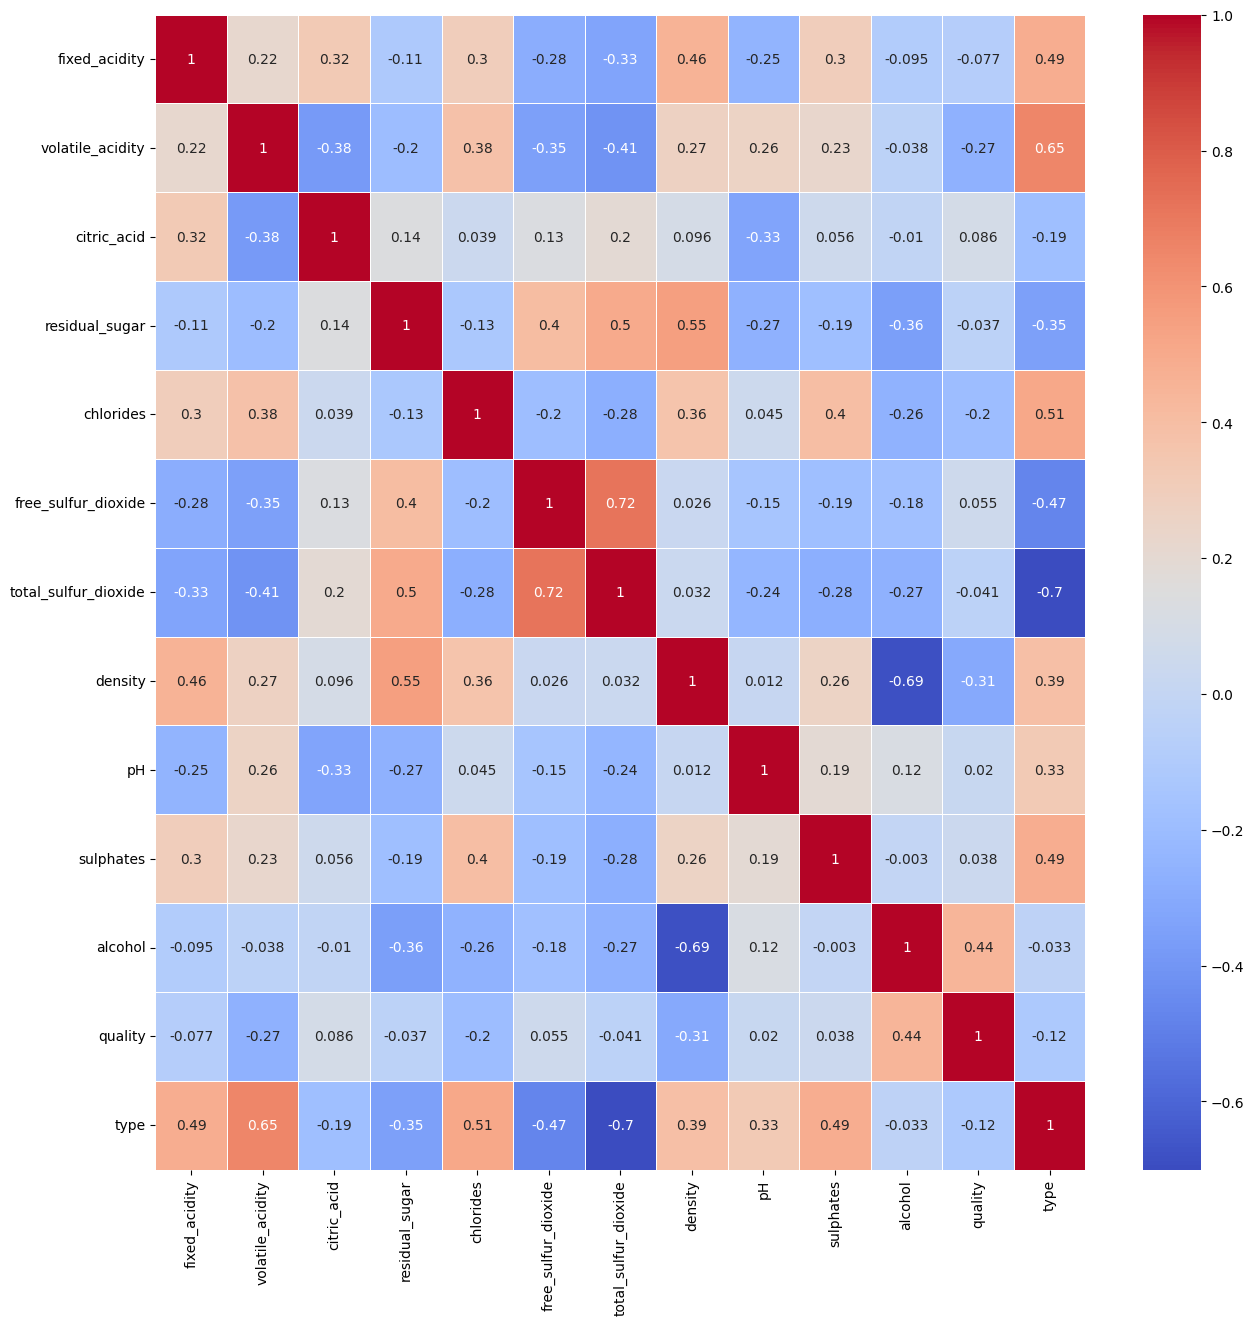

In [37]:
correlations = data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlations, annot = True, cmap ="coolwarm", linewidths = .5)
plt.show()

**Findings:** We observe a number of highly correlated features, namely: density & alchol (drop density)
We also see that more or less half of the features are highly correlated with the target value type

In [38]:
data = data.drop("density",axis=1)

array([[<Axes: title={'center': 'fixed_acidity'}>,
        <Axes: title={'center': 'volatile_acidity'}>,
        <Axes: title={'center': 'citric_acid'}>],
       [<Axes: title={'center': 'residual_sugar'}>,
        <Axes: title={'center': 'chlorides'}>,
        <Axes: title={'center': 'free_sulfur_dioxide'}>],
       [<Axes: title={'center': 'total_sulfur_dioxide'}>,
        <Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'sulphates'}>],
       [<Axes: title={'center': 'alcohol'}>,
        <Axes: title={'center': 'quality'}>,
        <Axes: title={'center': 'type'}>]], dtype=object)

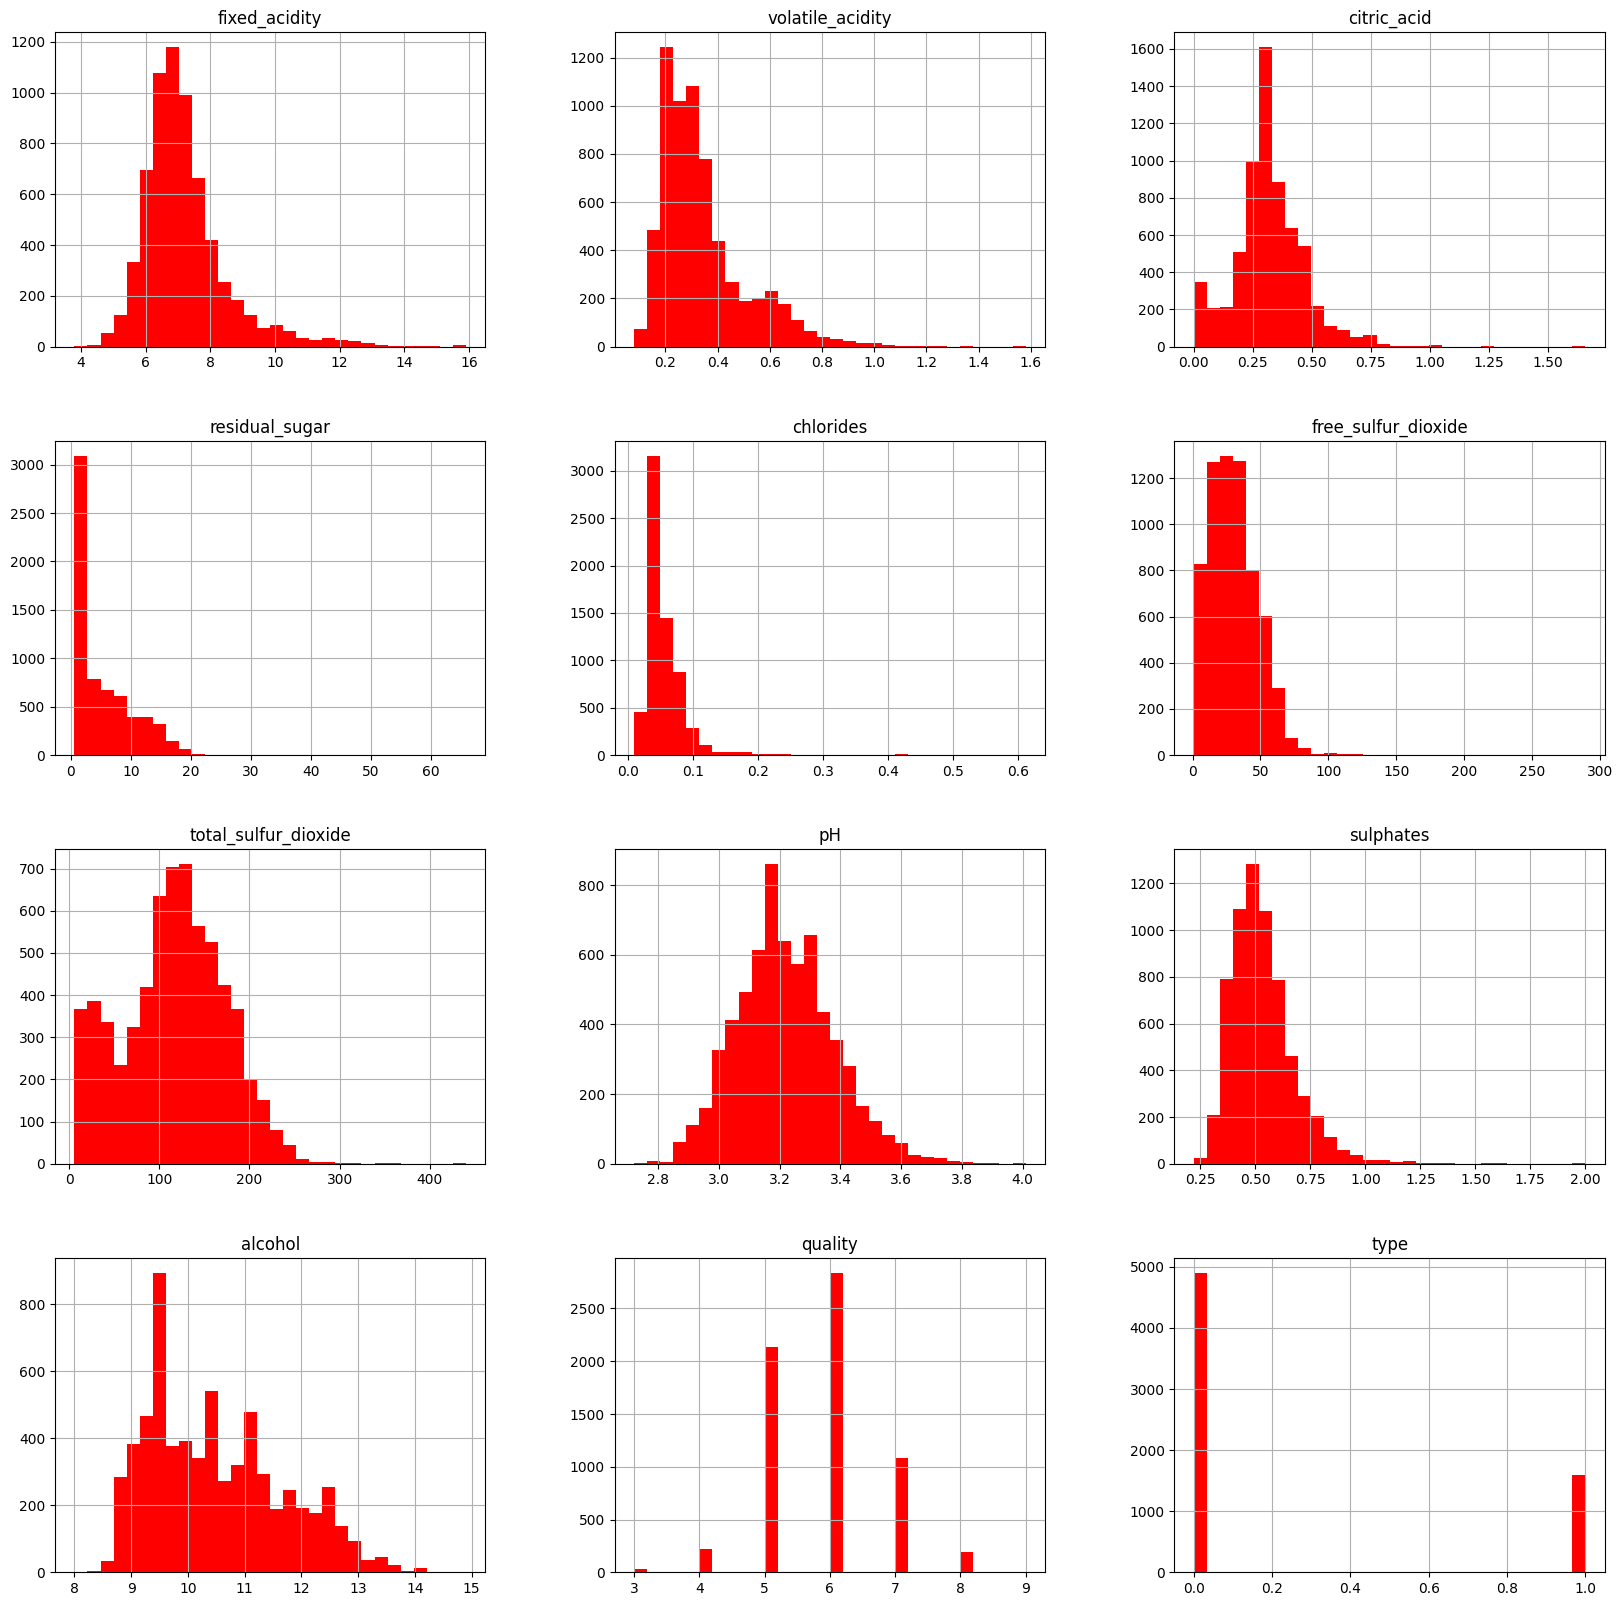

In [39]:
data.hist(bins = 30, figsize = (20,20), color = 'r')

**Finings:** Dataset is unbalanced - we should downsample the white wine (type = 0) to ensure our model is not getting skewed

In [40]:
# Create Target and Feature variables and split data into train and test
X = data.drop(columns=["type"], axis=1)
y = data["type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=99)

In [41]:
from sklearn.utils import resample
# Downsample Training Dats
# Concatenate X_train and y_train into a single DataFrame
df_train = pd.concat([X_train, y_train], axis=1)

# Separate the majority and minority classes
majority_class = df_train[df_train[y_train.name] == 0]
minority_class = df_train[df_train[y_train.name] == 1]

# Calculate the desired number of samples for the majority class
desired_count = len(minority_class)

# Randomly undersample the majority class
majority_downsampled = resample(majority_class, replace=False, n_samples=desired_count, random_state=99)

# Combine the downsampled majority class and the minority class
df_balanced_train = pd.concat([majority_downsampled, minority_class])

# Split the balanced DataFrame back into X_train and y_train
X_train = df_balanced_train.drop(columns=[y_train.name])
y_train = df_balanced_train[y_train.name]


In [42]:
# create dummy columns for categorical columns using OneHotEncoder

# find categorical columns
X_train_cat = X_train.select_dtypes(["int"])

# apply OHE to categorical columns
ohe = OneHotEncoder(sparse_output=False,handle_unknown='infrequent_if_exist')
cat_data_ohe = ohe.fit_transform(X_train_cat)
cat_data_ohe = pd.DataFrame(cat_data_ohe, columns=ohe.get_feature_names_out())

# join OHEed columns to the original X matrix
X_train_full = pd.concat([X_train.reset_index(drop=True), cat_data_ohe], axis=1)
X_train_full = X_train_full.drop(columns=X_train_cat.columns)

In [43]:
# Apply Scaler
scaler = StandardScaler()

X_train_full = scaler.fit_transform(X_train_full)

In [44]:
clf = LogisticRegression(solver='liblinear', max_iter=1000)

parameters = {
    'penalty': ['l2', 'l1'],
    'C': [0.01, 0.1, 1, 10],
}

search = RandomizedSearchCV(
    clf,                               # this is the instantiated estimator object, that is, the model we want to tune
    param_distributions=parameters,    # this is the predefinad search space
    scoring="roc_auc",                 # the metric we want the tuner calculates in order to select the best combination, roc_auc is usually the best sinc it is not sensitive to imbalanced data
    cv=3,                              # the cross-validation schema we want to use (same as in the "cross_validate" or "cross_val_score")
    refit=True,                        # if we want to fit again the model on the best hyp. setting found after the process
    n_jobs=-1,                         # this is to indicate the operative system to use all processor cores and speed up the process
    return_train_score=True,           # if we want the tuner also return the scores on training (not just in validation)
    n_iter=10                          # the number of attempts we want to perform, you can adjust this as needed
)


In [45]:
# Train Model
search.fit(X_train_full, y_train)

C:\Users\phili\anaconda3\envs\Python-1\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=1000,
                                                solver='liblinear'),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'penalty': ['l2', 'l1']},
                   return_train_score=True, scoring='roc_auc')

In [46]:
results = pd.DataFrame(search.cv_results_)
results = results.sort_values("mean_test_score", ascending=False)

In [48]:
# show the best 5 models
results.head().T

,2,0,5,3,4
mean_fit_time,0.006788,0.007885,0.006331,0.004517,0.006662
std_fit_time,0.001008,0.002804,0.000471,0.000859,0.000571
mean_score_time,0.01152,0.01844,0.004052,0.003218,0.00368
std_score_time,0.006038,0.004133,0.000072,0.000626,0.00048
param_penalty,l2,l2,l1,l1,l2
param_C,0.1,0.01,1,0.1,1
params,"{'penalty': 'l2', 'C': 0.1}","{'penalty': 'l2', 'C': 0.01}","{'penalty': 'l1', 'C': 1}","{'penalty': 'l1', 'C': 0.1}","{'penalty': 'l2', 'C': 1}"
split0_test_score,0.997657,0.997726,0.997355,0.997849,0.997334
split1_test_score,0.996654,0.996468,0.99664,0.996606,0.996599
split2_test_score,0.995446,0.995508,0.995247,0.994785,0.995288


In [49]:
# create dummy columns for categorical columns using OneHotEncoder
# fing categorical columns
X_test_cat = X_test.select_dtypes(["int"])

# apply OHE to categorical columns
cat_data_ohe = ohe.transform(X_test_cat)
cat_data_ohe = pd.DataFrame(cat_data_ohe, columns=ohe.get_feature_names_out())

# join OHEed columns to the original X matrix
X_test_full = pd.concat([X_test.reset_index(drop=True), cat_data_ohe], axis=1)
X_test_full = X_test_full.drop(columns=X_test_cat.columns)

# apply stanrdadization also to the test
X_test_full = scaler.transform(X_test_full)

In [50]:
pred_test = search.predict(X_test_full)
probas_test = search.predict_proba(X_test_full)

In [52]:
# Evaluation Metrics
precision_test = precision_score(y_test, pred_test, pos_label=1)
recall_test = recall_score(y_test, pred_test, pos_label=1)
f1_test = f1_score(y_test, pred_test, pos_label=1)
roc_auc_test = roc_auc_score(y_test, probas_test[:,1])

print(f"Test Precision: {round(precision_test,3)}")
print(f"Test Recall: {round(recall_test,3)}")
print(f"Test F1: {round(f1_test,3)}")
print(f"Test ROC_AUC: {round(roc_auc_test,3)}")

Test Precision: 0.963
Test Recall: 0.978
Test F1: 0.971
Test ROC_AUC: 0.991


In [53]:
import pickle

# Your trained machine learning model
model = search

# Specify the file path to save the model
model_file_path = 'wine.pkl'

# Open the file in binary write mode
with open(model_file_path, 'wb') as model_file:
    pickle.dump(model, model_file)


In [54]:
import pickle

# Save the scaler as a pickle file
scaler_filename = "wine_scaler.pkl"
with open(scaler_filename, "wb") as f:
    pickle.dump(scaler, f)